# Proximal Policy Optimization

### 0. Background: From REINFORCE to PPO

#### Basic: Vanilla Policy Gradient Function
In reinforcement learning, our goal is to **optimize a policy to maximize the rewards an agent can achieve (if we ignore discount factor for now)**. Algorithms like **[REINFORCE](../improved-reinforce/improved_reinforce.ipynb)** follow a simple yet repetitive process:

$$
\begin{align}
J(\theta') = \mathbb{E}_{\tau \sim P(\tau; \theta')} \left[ R(\tau) \right] = \sum_{\tau} P(\tau; \theta')  R(\tau) \\
P(\tau; \theta') = P(s_1) \prod_{t=1}^T \pi_{\theta'}(a_t | s_t) P(s_{t+1} | s_t, a_t) = \log P(s_1) + \sum_{t=1}^T  \log \pi_{\theta'}(a_t | s_t) + \log P(s_{t+1} | s_t, a_t)  \\
R(\tau) = \sum_{t=1}^T R_t^{\text{future}} \\
J(\theta') = \sum_{\tau}  \left( \log P(s_1) + \sum_{t=1}^T  \left( \log \pi_{\theta'}(a_t | s_t) + \log P(s_{t+1} | s_t, a_t) \right) \right) \sum_{t=1}^T R_t^{\text{future}} \\
J(\theta') = \sum_{\tau}  \left( \log P(s_1) \sum_{t=1}^T R_t^{\text{future}} + \sum_{t=1}^T  \left( \log \pi_{\theta'}(a_t | s_t) + \log P(s_{t+1} | s_t, a_t) \right) \sum_{t=1}^T R_t^{\text{future}} \right)  \\
J(\theta') = \sum_{\tau}  \left( \log P(s_1) \sum_{t=1}^T R_t^{\text{future}} + \sum_{t=1}^T  \left( \log \pi_{\theta'}(a_t | s_t) + \log P(s_{t+1} | s_t, a_t) \right) R_t^{\text{future}} \right)  \\
J(\theta') = \sum_{\tau}  \left( \log P(s_1) \sum_{t=1}^T R_t^{\text{future}} + \sum_{t=1}^T  \left( \log \pi_{\theta'}(a_t | s_t) R_t^{\text{future}} + \log P(s_{t+1} | s_t, a_t) R_t^{\text{future}} \right) \right)  \\
\end{align}
$$

1. Use the current policy $ \pi_\theta $ to generate trajectories (sequences of states, actions, and rewards).
2. Compute the policy gradient $ g $ based on these trajectories, $\log P(s_1) \sum_{t=1}^T R_t^{\text{future}}$ and $\log P(s_{t+1} | s_t, a_t) R_t^{\text{future}}$ not related to $ \pi_\theta $, it will cancel when compute gradient:
   $$
   \nabla_{\theta'} J(\theta') = g = \mathbb{E}_{\tau \sim P(\tau; \theta')} \left[ \sum_{t=1}^T \nabla_{\theta'} \log \pi_{\theta'}(a_t | s_t) \cdot R_t^{\text{future}} \right]
   $$
3. Update the policy parameters $ \theta $ using the gradient:  
   $$
   \theta' \gets \theta + \alpha g
   $$
4. Repeat the process until the policy becomes sufficiently good.

#### Issue 1: Wasted Trajectories in Policy Optimization

After updating the policy, the trajectories generated in step 1 are discarded. If we want to perform another update, we need to generate new trajectories using the updated policy $ \pi_{\theta'} $. This is computationally expensive and inefficient, as generating trajectories often constitutes the most time-consuming part of reinforcement learning.

A natural question arises: **Can we reuse the old trajectories instead of generating new ones every time?**

The answer is yes, but there’s a challenge: **Old trajectories are sampled from the distribution of the old policy $ \pi_\theta $, while we now want to optimize the new policy $ \pi_{\theta'} $.**

**But why Can't We Directly Use Old Trajectories?**

The key issue is that trajectories reflect the distribution of the policy that generated them. When the policy changes, the distribution of trajectories also changes. If we directly use old trajectories to compute gradients for the new policy, the results will be biased.

**An Analogy: Survey Sampling**
Imagine you conduct a survey to estimate the average income in a region. Initially, you sample participants based on age groups. Later, you realize that sampling based on professions would yield more accurate results. Instead of conducting the survey again, you could assign **weights** to the old samples to make them more representative of the new sampling strategy.

In reinforcement learning:
- Trajectories are like survey samples.
- The old and new policies define the sampling strategies.
- Importance sampling provides the weights to adjust old trajectories for the new policy.

#### Imporvement 1: Importance Sampling

**Importance Sampling** is a technique that allows us to reuse samples (trajectories) generated from one distribution to estimate expectations under another distribution.

If we want to compute the expectation of some quantity $ f(\tau) $ under the new policy $ \pi_{\theta'} $, such as policy gradient:
$$
\mathbb{E}_{\pi_{\theta'}}[f(\tau)] = \sum_{\tau} P(\tau; \theta') f(\tau)
$$

We can rewrite it using the old policy $ \pi_\theta $:
$$
\begin{align}
\mathbb{E}_{\pi_{\theta'}}[f(\tau)] = \sum_{\tau} P(\tau; \theta) \cdot \frac{P(\tau; \theta')}{P(\tau; \theta)} \cdot f(\tau) \\

\mathbb{E}_{\pi_{\theta'}}[f(\tau)] = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \frac{P(\tau; \theta')}{P(\tau; \theta)} f(\tau) \right]
\end{align}
$$


Here:
- $ P(\tau; \theta) $: Probability of trajectory $ \tau $ under the old policy.
- $ P(\tau; \theta') $: Probability of trajectory $ \tau $ under the new policy.
- $ \frac{P(\tau; \theta')}{P(\tau; \theta)} $: The **importance weight**, which adjusts the contribution of each trajectory to reflect the new policy.


##### Re-weighting the Policy Gradient

When updating the current policy  $ \pi_{\theta'}  $, we only have trajectories generated by an older policy  $ \pi_{\theta}  $. To compute the gradient  $ g  $, we use **importance sampling**. The gradient can be expressed as:

$$
\begin{align}
\mathbb{E}_{\pi_{\theta'}}[f(\tau)] = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \frac{P(\tau; \theta')}{P(\tau; \theta)} f(\tau) \right] \\

f(\tau) = \sum_{t=1}^T \nabla_{\theta'} \log \pi_{\theta'}(a_t | s_t) \cdot R_t^{\text{future}} \\

\nabla_{\theta'} J(\theta') = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \frac{P(\tau; \theta')}{P(\tau; \theta)} \sum_{t=1}^T \nabla_{\theta'} \log \pi_{\theta'}(a_t | s_t) \cdot R_t^{\text{future}} \right] \\
\end{align}
$$

Here:
-  $ \frac{P(\tau; \theta')}{P(\tau; \theta)}  $ is the **re-weighting factor**, which accounts for the difference between the old and new policies.
-  $ R_t^{\text{future}}  $ is the future cumulative reward at time step  $ t  $.
-  $ \nabla_{\theta'} \pi_{\theta'}(a_t | s_t)  $ is the gradient of the new policy.

The trajectory-level re-weighting factor  $ \frac{P(\tau; \theta')}{P(\tau; \theta)}  $ can be decomposed into a product of per-step policy ratios:

$$
\frac{P(\tau; \theta')}{P(\tau; \theta)} = \prod_{t=1}^T \frac{\pi_{\theta'}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)}
$$

Substituting this into the gradient expression, we get:

$$
\nabla_{\theta'} J(\theta') = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \prod_{t=1}^T \frac{\pi_{\theta'}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)} \sum_{t=1}^T \nabla_{\theta'} \log \pi_{\theta'}(a_t | s_t) \cdot R_t^{\text{future}} \right]
$$

However, if the old policy  $ \pi_{\theta}  $ and the new policy  $ \pi_{\theta'}  $ are **close enough**, the per-step policy ratios  $ \frac{\pi_{\theta'}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)}  $ will be approximately 1. This allows us to simplify the gradient by only compute ratio in every step:

$$
\nabla_{\theta'} J(\theta') \approx \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=1}^T \frac{\pi_{\theta'}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)} \nabla_{\theta'} \log \pi_{\theta'}(a_t | s_t) \cdot R_t^{\text{future}} \right]
$$

This expression resembles the **vanilla policy gradient**, but it explicitly accounts for differences between the old and new policies.

##### The Surrogate Function

We can interpret this approximate gradient as the gradient of a new objective, called the **surrogate function**:

$$
\nabla_{\theta'} L_{\text{sur}}(\theta', \theta) = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=1}^T \frac{\pi_{\theta'}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)}  \cdot \nabla_{\theta'} \log \pi_{\theta'}(a_t | s_t) \cdot R_t^{\text{future}} \right]
$$


based existed equation $ \nabla_{\theta'} \pi_{\theta'}(a_t | s_t) = \pi_{\theta'}(a_t | s_t) \cdot \nabla_{\theta'} \log \pi_{\theta'}(a_t | s_t) $, we have：

$$
\frac{\pi_{\theta'}(a_t | s_t)}{\pi_\theta(a_t | s_t)} \cdot \nabla_{\theta'} \log \pi_{\theta'}(a_t | s_t) = \nabla_{\theta'} \frac{\pi_{\theta'}(a_t | s_t)}{\pi_\theta(a_t | s_t)}
$$

$$
\nabla_{\theta'} L_{\text{sur}}(\theta', \theta) = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \nabla_{\theta'}  \sum_{t=1}^T \frac{\pi_{\theta'}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)} \cdot R_t^{\text{future}} \right]
$$


Where the surrogate function is defined as:

$$
L_{\text{sur}}(\theta', \theta) = \mathbb{E}_{\tau \sim P(\tau; \theta)} \left[ \sum_{t=1}^T \frac{\pi_{\theta'}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)} \cdot R_t^{\text{future}} \right]
$$

Using this surrogate function, we can perform gradient ascent to update the policy, effectively maximizing  $ L_{\text{sur}}  $.


#### Issue 2: The Policy/Reward Cliff Problem

In reinforcement learning, optimizing a policy can lead to a critical issue: **if we ignore the validity of approximations and update the policy too aggressively, it may result in catastrophic failure**. Specifically, the policy might fall off a "reward cliff," ending up in a bad state that is difficult to recover from.


<div style="text-align: center;">
    <img src="./images/clipsurrogate-explain1.png" alt="Mountain Car Environment" width="50%">
</div>


1. **Current vs. Optimal Policy**:
   - Assume we have a policy $ \pi_{\theta'} $ (red line in the left plot).
   - The average reward function is shown as the black line in the right plot.
   - The current policy is marked in red, and the goal is to update it to the optimal policy (green star).

2. **Role of the Surrogate Function**:
   - To update the policy, we compute a **surrogate objective** $ L_{\text{sur}} $ (red dotted curve in the right plot).
   - $ L_{\text{sur}} $ approximates the reward well near the current policy but diverges far away.

3. **Risk of Policy Updates**:
   - If we perform gradient ascent repeatedly (red dots in the right plot), the policy might encounter a "cliff."
   - At the cliff, $ L_{\text{sur}} $ suggests a high reward, but the actual reward is very low.
   - Worse, the policy may get stuck in a flat, deep region, making recovery nearly impossible.


#### Improvement 2: Clipped Surrogate Function

<div style="text-align: center;">
    <img src="./images/clipsurrogate-explain2.png" alt="Mountain Car Environment" width="50%">
</div>

1. **Key Idea**:
   - Modify the surrogate function $ L_{\text{sur}} $ into a **clipped version** $ L_{\text{sur,clip}} $ that flattens near cliffs.
   - This ensures that gradient ascent stops before the policy falls off the cliff.

2. **Update Dynamics**:
   - Starting from the current policy (blue dot), gradient ascent proceeds until it reaches the flat region of $ L_{\text{sur,clip}} $ (blue curve).
   - At this point, the gradient becomes zero, and updates stop.


The clipped surrogate function is defined as:

$$
L_{\text{sur,clip}}(\theta', \theta) = \sum_t \min \left\{ \frac{\pi_{\theta'}(a_t | s_t)}{\pi_\theta(a_t | s_t)} R_t^{\text{future}}, \text{clip}_\epsilon \left( \frac{\pi_{\theta'}(a_t | s_t)}{\pi_\theta(a_t | s_t)} \right) R_t^{\text{future}} \right\}
$$


1. **Policy Similarity**:
   - Keep the new policy $ \pi_{\theta'} $ close to the old policy $ \pi_\theta $ by keeping the ratio near 1.

2. **Conservative Reward Estimation**:
   - The clipped surrogate function gives a more conservative reward estimate, preventing overly aggressive updates.

3. **High-Dimensional Cliffs**:
   - In practice, policies have thousands of parameters, and cliffs may exist in many directions.
   - Clipping handles these cliffs automatically in all dimensions.



### 1. Import the Necessary Packages

In this notebook, we will implement PPO and train a policy to play [atari-pong](https://ale.farama.org/environments/pong/), using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy.


In [1]:
import numpy as np
from enum import Enum
import ale_py
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from parallel_env import ParallelEnv
from plot_utils import display_frame, save_animation, plot_scores


%matplotlib inline
gym.register_envs(ale_py)

device = torch.device("cuda:0" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print("using device: ",device)

using device:  mps


### 2. Explore Environment

<div style="text-align: center;">
    <img src="./images/pong.gif" alt="Mountain Car Environment" width="10%">
</div>

#### Continuous State Space
- **Observation Type**: `"rgb"`
- **Observation Space**: `Box(0, 255, (210, 160, 3), np.uint8)`
  - Observations are RGB images with dimensions 210x160 and 3 color channels. The pixel values range from 0 to 255.

#### Discrete Action Space
- **Type**: `Discrete(6)`
- **Actions**:
  - `0`: `NOOP` (No operation)
  - `1`: `FIRE`
  - `2`: `RIGHT`
  - `3`: `LEFT`
  - `4`: `RIGHTFIRE`
  - `5`: `LEFTFIRE`

> To simplify training, we will only use the following two actions:
> - `4`: `RIGHTFIRE`
> - `5`: `LEFTFIRE`

The `FIRE` part ensures the game starts again after losing a life.

#### Other Settings
1. **Frameskip**
    - **Value**: `4`
    - **Explanation**: The environment executes the same action for 4 consecutive frames before observing the next state. This deterministic frameskip makes the environment faster to train compared to the vanilla `Pong-v4`, which uses a stochastic frameskip of `(2, 5)`.

2. **Repeat Action Probability**
    - **Value**: `0.0`
    - **Explanation**: This setting ensures no randomness in action repetition. The same action will always have the same effect, making the environment fully deterministic and predictable.

By using deterministic frameskip and disabling action stickiness, `PongDeterministic-v4` is more efficient for training reinforcement learning models.


In [2]:
env = gym.make('PongDeterministic-v4')

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


In [3]:
# Explore state (observation) space
print("State space:\n", env.observation_space)

# Explore action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("Shape of State space 2 samples:")
print([env.observation_space.sample().shape for _ in range(2)])

# Generate some samples from the action space
print("Action space 2 samples:")
print(np.array([env.action_space.sample() for i in range(2)]))

State space:
 Box(0, 255, (210, 160, 3), uint8)
Action space:
 Discrete(6)
--------------------------------------------------
Shape of State space 2 samples:
[(210, 160, 3), (210, 160, 3)]
Action space 2 samples:
[5 3]


In [4]:
class Action(Enum):
    NOOP = 0         # No operation
    FIRE = 1         # Fire
    RIGHT = 2        # Move right
    LEFT = 3         # Move left
    RIGHTFIRE = 4    # Move right and fire
    LEFTFIRE = 5     # Move left and fire

### 3. Preprocessing

To speed up training, we can simplify the input by cropping the images and use every other pixel

<div style="text-align: center;">
    <img src="./images/preprocess.png" alt="Mountain Car Environment" width="50%">
</div>


In [5]:
def preprocess(image, bkg_color=np.array([144, 72, 17])):
    """
    Preprocess a single game frame by cropping, downsampling, and normalizing.

    Args:
        image (np.ndarray): The input image (game frame) as a NumPy array.
        bkg_color (np.ndarray): The RGB background color to subtract.

    Returns:
        np.ndarray: The processed image, normalized to [0, 1].
    """
    # Crop the image to remove irrelevant parts (e.g., score and borders)
    cropped_image = image[34:-16, :]
    # Downsample the image by taking every second pixel (both rows and columns)
    downsampled_image = cropped_image[::2, ::2]
    # Subtract the background color
    adjusted_image = downsampled_image - bkg_color
    # Convert to grayscale by taking the mean across the color channels
    grayscale_image = np.mean(adjusted_image, axis=-1)
    # Normalize pixel values to the range [0, 1]
    normalized_image = grayscale_image / 255.0

    return normalized_image


def preprocess_batch(images, bkg_color=np.array([144, 72, 17])):
    """
    Convert outputs of ParallelEnv to inputs for tensor processing.

    Args:
        images (list or np.ndarray): Batch of input images (game frames).
        bkg_color (np.ndarray): The RGB background color to subtract.
        device (str): The device to which the tensor will be moved (e.g., "cpu" or "cuda").

    Returns:
        torch.Tensor: The processed batch of images as a tensor, normalized to [0, 1].
    """
    # Ensure images are in a NumPy array
    # shape: (time_steps, height, width, channel)
    batch_images = np.asarray(images)

    # If the input has less than 5 dimensions, expand the dimensions
    # shape: (time_steps, batch, height, width, channels)
    if len(batch_images.shape) < 5:
        batch_images = np.expand_dims(batch_images, 1)

    # Process each image in the batch using logic from the preprocess function
    # shape: (time_steps, batch, height, width, channels)
    cropped_images = batch_images[:, :, 34:-16, :, :]  # Crop the images
    downsampled_images = cropped_images[:, :, ::2, ::2, :]  # Downsample the images
    adjusted_images = downsampled_images - bkg_color  # Subtract the background color
    
    # Convert to grayscale and normalize pixel values to [0, 1]
    # shape: (time_steps, batch, height, width)
    grayscale_images = np.mean(adjusted_images, axis=-1)  
    normalized_images = grayscale_images / 255.0

    # Rearrange the batch dimension to match the expected input format
    # shape: (batch, time_steps, height, width) or in other way
    #        (batch, channel, height, width)
    batch_input = torch.from_numpy(normalized_images).float()
    batch_input = batch_input.permute(1, 0, 2, 3)
    return batch_input


Original Frame Shape: (210, 160, 3)
Processed Frame Shape: (80, 80)


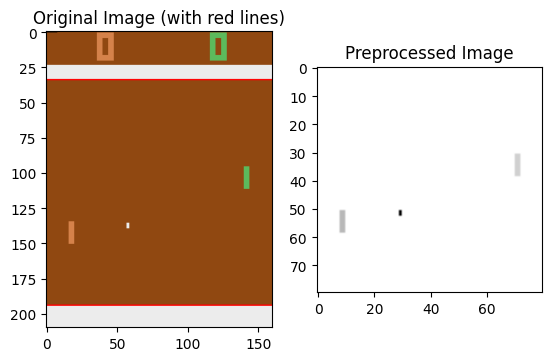

In [6]:
# Test: get 20-th frame
env.reset()
for _ in range(20):
    action = 1 # fire
    frame, *_ = env.step(action)

processed_frame = preprocess(frame)

display_frame(frame, processed_frame)

### 4. Define Policy

Here, we define our policy. Similar to [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf), we modify the architechture of network for this problem.

- Action Value Network in DQN

<div style="text-align: center;">
    <img src="./images/dqn-network.png" alt="Mountain Car Environment" width="50%">
</div>

- Policy Network in Reinforce
  - input is the stack of two different frames (which captures the movement)
  - output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

<div style="text-align: center;">
    <img src="./images/policy-network.png" alt="Mountain Car Environment" width="60%">
</div>


In [7]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        self.RIGHTFIRE = Action.RIGHTFIRE.value
        self.LEFTFIRE = Action.LEFTFIRE.value
        
        # 80x80x2 input
        # Conv layers with progressively decreasing spatial dimensions
        # outputsize = (inputsize - kernel_size + stride) / stride
        # (round up if not an integer)

        # First convolutional layer: input 80x80x2 -> output 20x20x32
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4, stride=4)
        
        # Second convolutional layer: input 20x20x32 -> output 9x9x64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)

        # Third convolutional layer: input 9x9x64 -> output 7x7x64
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Flatten the output of the conv layers
        self.size = 7 * 7 * 64  # Flattened size after conv layers
        
        # Fully connected layers: progressively decreasing sizes
        self.fc1 = nn.Linear(self.size, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 1)           # Final fully connected layer (output)
        
        
    def forward(self, x):
        # Pass through the convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten the tensor
        x = x.view(-1, self.size)
        
        # Pass through the fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        
        # the output is the probability of moving right, P(right)
        # so, for moving left, have P(left) = 1-P(right)
        return x

    @torch.no_grad()
    def select_action(self, frames, mode='inference'):
        """
        Select actions based on policy for either inference or trajectory collection.
        
        Args:
            frames: Tuple of (frame1, frame2) or preprocessed tensor
            mode: Either 'inference' for single action or 'collect' for trajectory collection
            
        Returns:
            For mode='inference': single action value
            For mode='collect': tuple of (states, actions, action_probs)
        """
        # Ensure frames are on the correct device
        if isinstance(frames, tuple):
            states = preprocess_batch(frames).to(next(self.parameters()).device)
        else:
            states = frames.to(next(self.parameters()).device)
        
        # Get action probabilities
        probs = self(states).squeeze().detach().cpu().numpy()
        
        if mode == 'inference':
            # Single instance inference
            action = self.RIGHTFIRE if np.random.random() < probs else self.LEFTFIRE
            return action
        
        elif mode == 'collect':
            # Batch processing for trajectory collection
            n = probs.shape[0]
            
            # Generate random values for all instances
            random_values = np.random.rand(n)
            
            # Select actions based on probabilities
            actions = np.where(
                random_values < probs,
                self.RIGHTFIRE,
                self.LEFTFIRE
            )
            
            # Calculate action probabilities
            action_probs = np.where(
                actions == self.RIGHTFIRE,
                probs,
                1.0 - probs
            )
            
            return states, actions, action_probs
        
        else:
            raise ValueError(f"Unknown mode: {mode}. Use 'inference' or 'collect'")

    def get_action_probs(self, states, actions):
        """
        Get probabilities for given states and actions.
        Useful for calculating policy gradients.
        
        Args:
            states: Preprocessed state tensor
            actions: Tensor of actions taken
            
        Returns:
            Tensor of action probabilities
        """
        probs = self(states).squeeze()
        probs = probs.view(*actions.shape)
        action_probs = torch.where(
            actions == self.RIGHTFIRE,
            probs,
            1.0 - probs
        )
        return action_probs
        

policy = Policy().to(device)
policy

Policy(
  (conv1): Conv2d(2, 32, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

In [8]:
# we use the adam optimizer with learning rate 1e-4
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

### 5. Game Visualization
Visualize the interaction process of the environment and the policy.

<div style="text-align: center;">
    <img src="./images/interact.png" alt="Mountain Car Environment" width="60%">
</div>

In [9]:
# Random action function using numpy broadcasting
def get_random_action(n):
    return np.random.choice(
        [Action.RIGHTFIRE.value, Action.LEFTFIRE.value],
        size=n
    )

print(f"Sample action on inference: {get_random_action(1).item()}")
print(f"Sample action on collect: {get_random_action(4)}")

Sample action on inference: 5
Sample action on collect: [5 4 4 5]


In [10]:
def perform_random_steps(env, nrand, parallel=False):
    """
    Perform a number of random steps in the environment to initialize the game.
    Supports both single and parallel environments.
    
    Args:
        env: The game environment (single or parallel)
        nrand (int): Number of random steps to perform
        parallel (bool): Whether the environment is parallel
        
    Returns:
        tuple: The last two frames after performing random steps
    """
    # Reset environment
    env.reset()

    # Get environment size (1 for single env, n for parallel envs)
    n = len(env.ps) if parallel else 1
    
    # Unified action definitions
    fire_action = np.full(n, Action.FIRE.value, dtype=np.int32)
    noop_action = np.full(n, Action.NOOP.value, dtype=np.int32)
    
    # Start the game with a FIRE action
    env.step(fire_action.item() if n == 1 else fire_action)
    
    # Initialize frames
    frames1, frames2 = None, None

    # Perform random steps
    for _ in range(nrand):
        # Get and format random action
        action = get_random_action(n)
        frames1, _, dones, *_ = env.step(action.item() if n == 1 else action)
        frames2, _, dones, *_ = env.step(noop_action.item() if n == 1 else noop_action)
        
        # Check termination condition
        if (dones if n == 1 else dones.any()):
            break
    
    return frames1, frames2

In [11]:
def interact(env, policy, max_t=2000, preprocess=None, nrand=5):
    """
    Play a game using the given policy and display the animation.

    Args:
        env: The game environment.
        policy: The policy function to decide actions.
        max_t (int): Maximum number of timesteps to play.
        preprocess (callable): Function to preprocess frames (optional).
        nrand (int): Number of random steps before using the policy.

    Returns:
        None
    """

    # Initialize the game and perform random steps
    frame1, frame2 = perform_random_steps(env, nrand)

    selected_frames = []
    for _ in range(max_t):
        # Select an action using the policy
        action = policy.select_action((frame1, frame2), mode='inference')

        # Perform the action and a NOOP step
        frame1, _, done, *_ = env.step(action)
        frame2, _, done, *_ = env.step(Action.NOOP.value)

        # Store the frame (preprocessed or raw)
        selected_frames.append(preprocess(frame1) if preprocess else frame1)

        # End the game if done
        if done:
            break

    env.close()
    save_animation(selected_frames)

Animation saved to animation.mp4


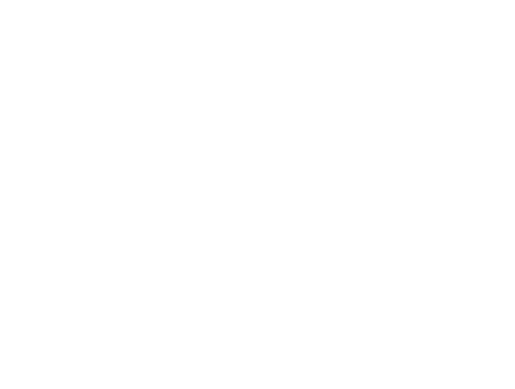

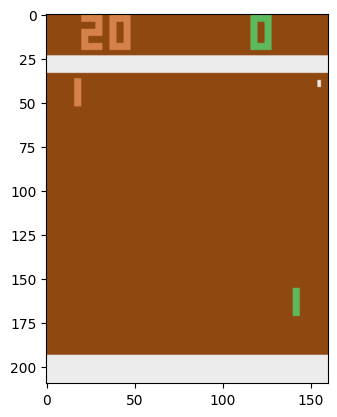

In [12]:
# after interact, open animation.mp4 see whole interact process
interact(env, policy, max_t=2000, nrand=5)

### 6. Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once


<div style="text-align: center;">
    <img src="./images/parallel-collect.png" alt="Mountain Car Environment" width="60%">
</div>

In [13]:
envs = ParallelEnv('PongDeterministic-v4', n=8, seed=42)

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]
A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


In [14]:
# collect trajectories for a parallelized parallelEnv object
def collect_trajectories(envs, policy, max_t=200, nrand=5):

    # number of parallel instances
    n = len(envs.ps)

    # initialize returning lists and start the game!
    states = torch.zeros(max_t, n, 2, 80, 80, device=device)
    rewards = torch.zeros(max_t, n, device=device)
    probs = torch.zeros(max_t, n, device=device)
    actions = torch.zeros(max_t, n, dtype=torch.int8, device=device)

    # Initialize the game and perform random steps
    frame1, frame2 = perform_random_steps(envs, nrand, parallel=True)

    for t in range(max_t):

        # Predict actions
        state, action, actions_prob = policy.select_action((frame1, frame2), mode='collect')

        # Advance the game, we take one action and skip game forward
        frame1, reward1, done, _ = envs.step(action)
        frame2, reward2, done, _ = envs.step([Action.NOOP.value] * n)

        reward = reward1 + reward2

        # store the result
        states[t] = state
        rewards[t] = torch.from_numpy(reward)
        probs[t] = torch.from_numpy(actions_prob)
        actions[t] = torch.from_numpy(action)

        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if done.any():
            break
    
    # Convert time steps dimension into batch for vectorize inference
    states = states.view(-1, 2, 80, 80)
    
    return states, actions, probs, rewards


In [15]:
trajectories = collect_trajectories(envs, policy, max_t=100)
states, actions, probs, rewards = trajectories

### 7. Define Objective Function

**Future Rewards Matrix $R^{\rm future}$**

<div style="text-align: center;">
    <img src="./images/discounts.png" alt="Mountain Car Environment" width="60%">
</div>

**Policy Gradient**

$$
\nabla_\theta U(\theta) \approx \hat{g} = \frac{1}{B} \frac{1}{T} \sum_{i=1}^B \sum^T_t \nabla_\theta \log(\pi_{\theta'}(a_t|s_t)) R_{t} 
$$

where $B$ is number of environments

**Policy Gradient with Future Rewards (in Imporved REINFORCE)**

$$
\nabla_\theta U(\theta) \approx \hat{g} = \frac{1}{B} \frac{1}{T} \sum_{i=1}^B \sum^T_t \nabla_\theta \log(\pi_{\theta'}(a_t|s_t)) R_{t}^{\rm future}
$$

**Surrgate Function as Approximate Policy Gradient with Future Rewards (in PPO)**

$$
\nabla_{\theta'} L_{\text{sur}}(\theta', \theta) = \frac{1}{B} \frac{1}{T} \sum_{i=1}^B \sum^T_t \frac{\pi_{\theta'}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)}  \cdot \nabla_{\theta'} \log \pi_{\theta'}(a_t | s_t) \cdot R_t^{\text{future}}
$$

$$
L_{\text{sur}}(\theta', \theta) = g = \frac{1}{B}\frac{1}{T}  \sum_{t=1}^T \frac{\pi_{\theta'}(a_t | s_t)}{\pi_{\theta}(a_t | s_t)} \cdot R_t^{\text{future}} 
$$

**Regularization Term for balance exploration and exploitation (in TRPO)**

The parameters $ \theta $ (old policy) and $ \theta' $ (new policy) play a crucial role in balancing exploration and exploitation. By controlling the update between $ \theta $ and $ \theta' $, the policy can gradually shift its behavior without deviating too far from the previous policy. This ensures that the agent explores new actions while leveraging the knowledge gained from past experiences. The entropy regularization term further enhances this process by encouraging randomness in action selection, preventing the policy from becoming overly deterministic too quickly.

Dynamically adjusts the trade-off between exploring new actions (high entropy) and exploiting learned actions (low entropy) by tuning the weight $ \beta $. 

Entropy regularization is a key component in modern reinforcement learning algorithms like PPO and A3C, enabling robust and efficient training.

$$
H(\pi_{\theta'}, \pi_{\theta}) = - \frac{1}{B} \frac{1}{T} \sum_{i=1}^B \sum^T_t \pi_{\theta'}(a_t|s_t) \log\pi_{\theta}(a_t|s_t)
$$

where $\theta$ is previous policy and $\theta'$ is current policy

**Final Policy Gradient**

$$
\nabla_\theta U(\theta) \approx  \nabla_\theta \left[ g + \beta * H(\pi_{\theta'}, \pi_{\theta}) \right]
$$



In [16]:
def compute_future_rewards(rewards, gamma=0.99):
    """
    Compute future rewards using discount factors and matrix multiplication.
    
    Args:
        rewards: Tensor of rewards [T]
        gamma: Discount factor
        
    Returns:
        future_rewards: Tensor of future rewards [T]
    """
    T = len(rewards)
    indices = torch.arange(T).to(device=rewards.device)
    discounts_matrix = gamma ** (indices.unsqueeze(0) - indices.unsqueeze(1)).clamp_min(0)
    mask = torch.triu(torch.ones(T, T)).to(device=rewards.device)
    future_rewards = torch.matmul(discounts_matrix * mask, rewards)

    mean = future_rewards.mean(dim=1, keepdim=True)
    std = future_rewards.std(dim=1, keepdim=True)
    future_rewards = (future_rewards - mean) / (std + 1e-10)

    return future_rewards

print("Future rewards shape:", compute_future_rewards(rewards).shape)

Future rewards shape: torch.Size([100, 8])


In [17]:
def clipped_surrogate(
    policy, states, actions, old_probs, rewards, gamma=0.995, beta=0.01, epsilon=0.1
):

    # Compute and normalize future rewards
    future_rewards = compute_future_rewards(rewards, gamma=gamma)

    # Convert states to probability
    # probs shape: (time_steps, batch_size)
    probs = policy.get_action_probs(states, actions)

    # Compute policy gradient
    # (1/B)(1/T)∑∑ π_θ'(a_t|s_t)/ π_θ(a_t|s_t) * R_t^future
    # g shape: (time_steps, batch_size)
    ratio = probs / old_probs
    clip = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
    g = torch.min(ratio * future_rewards, clip * future_rewards)

    # Regularization term
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(
        probs * torch.log(old_probs + 1.0e-10)
        + (1.0 - probs) * torch.log(1.0 - old_probs + 1.0e-10)
    )

    return torch.mean(g + beta * entropy)


pg = clipped_surrogate(policy, states, actions, probs, rewards)
pg

tensor(0.0069, device='mps:0', grad_fn=<MeanBackward0>)

### 8. Training
We are now ready to train our policy!

**Multiple steps training**

It may take up to 25 minutes with Apple M3 Max GPU.

In [18]:
def ppo(
    envs,
    policy,
    optimizer,
    n_episodes=500,
    gamma=0.99,
    epsilon=0.1,
    beta=0.01,
    max_t=320,
    window=20,
    epoch=4,
    checkpoint_path="checkpoint.pth",
):
    """
    Improved REINFORCE algorithm implementation with parallel environments

    Parameters:
    -----------
    envs : list or VectorEnv
        List of environments or vectorized environment
    policy : nn.Module
        Policy network
    optimizer : torch.optim.Optimizer
        Optimizer for policy network
    n_episodes : int
        Number of episodes to train
    epoch : int
        Number of policy updates on history trajectories
    gamma : float
        Discount factor
    epsilon : float
        Clip factor
    beta : float
        Entropy coefficient for exploration
    max_t : int
        Maximum number of timesteps per episode
    window : int
        How often to print progress
    checkpoint_path : str
        Path to save the model checkpoint

    Returns:
    --------
    scores : list
        List of mean rewards per episode
    """
    n = len(envs.ps)

    # keep track of progress
    scores = []
    best_score = float("-inf")
    for i_episode in range(1, n_episodes + 1):
        # collect trajectories
        states, actions, probs, rewards = collect_trajectories(
            envs, policy, max_t=max_t
        )

        # gradient ascent step
        for _ in range(epoch):
            pg = clipped_surrogate(
                policy,
                states,
                actions,
                probs,
                rewards,
                gamma=gamma,
                epsilon=epsilon,
                beta=beta,
            )
            loss = -pg
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # reduce exploration over time
        beta *= 0.995

        # reduce clip factor over time
        epsilon *= 0.999

        # calculate total rewards
        total_rewards = rewards.sum(dim=0)

        # display progress
        avg_score = total_rewards.mean().item()

        # store mean reward on batch
        scores.append(avg_score)

        if avg_score > best_score:
            best_score = avg_score
            torch.save(policy.state_dict(), checkpoint_path)
            print(f"Checkpoint saved with new best score: {best_score:.2f}")

        if i_episode % window == 0:
            print(f"Episode {i_episode}\tAverage Score: {avg_score:.2f}")
            print(f"Total Rewards on {n} envs: {total_rewards.cpu().numpy()}")

    return scores

In [19]:
# step1: using a small max_t=200 with 500 episodes
scores = ppo(
    envs=envs,
    policy=policy,
    optimizer=optimizer,
    n_episodes=600,
	epoch=4,
    gamma=0.99,
	epsilon=0.1,
    beta=0.01,
    max_t=320,
	window=20
)

Checkpoint saved with new best score: -15.12
Checkpoint saved with new best score: -13.88
Checkpoint saved with new best score: -11.62
Episode 20	Average Score: -13.62
Total Rewards on 8 envs: [-13. -11. -13. -15. -15. -16. -16. -10.]
Episode 40	Average Score: -14.25
Total Rewards on 8 envs: [-15. -14. -14. -15. -16. -13. -10. -17.]
Episode 60	Average Score: -15.00
Total Rewards on 8 envs: [-16. -17. -14. -16. -16. -16. -16.  -9.]
Episode 80	Average Score: -13.50
Total Rewards on 8 envs: [-16. -12. -16. -11. -16. -14. -13. -10.]
Episode 100	Average Score: -12.25
Total Rewards on 8 envs: [-15. -13.  -8. -10.  -7. -16. -13. -16.]
Episode 120	Average Score: -12.62
Total Rewards on 8 envs: [-13. -12. -12. -16. -13. -11. -14. -10.]
Checkpoint saved with new best score: -11.12
Checkpoint saved with new best score: -10.88
Episode 140	Average Score: -12.25
Total Rewards on 8 envs: [-14. -13. -13. -11. -12. -10. -10. -15.]
Checkpoint saved with new best score: -10.25
Checkpoint saved with new b

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
        ...   
595    1.73125
596    1.71250
597    1.77500
598    1.73125
599    1.69375
Length: 600, dtype: float64

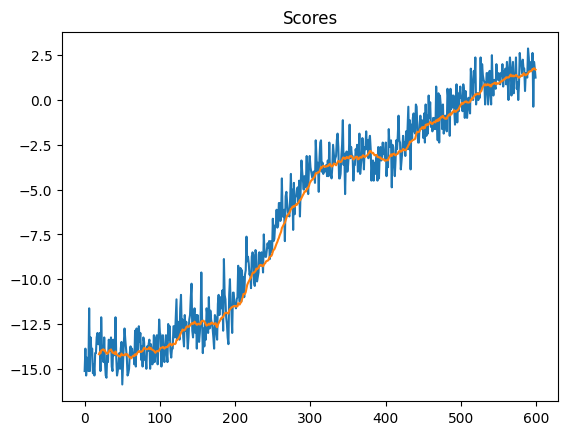

In [21]:
plot_scores(scores, rolling_window=20)

Animation saved to animation.mp4


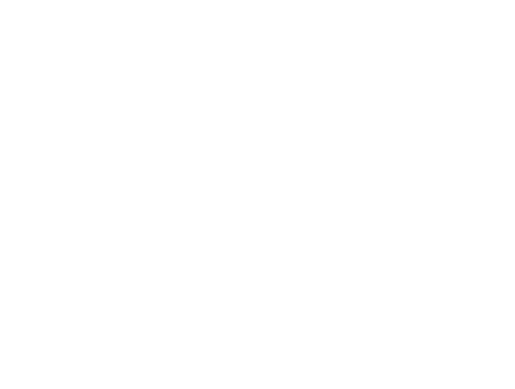

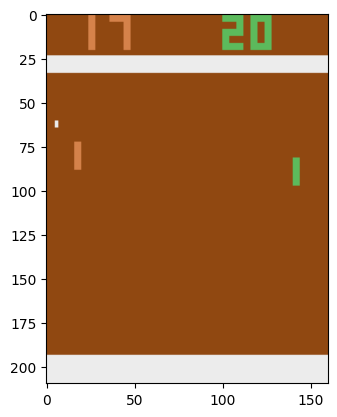

In [22]:
# play game after training!
policy.load_state_dict(torch.load('checkpoint.pth', weights_only=True))
interact(env, policy, max_t=2000)